In [285]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  
import math
import random

In [286]:
# Fonction de normalisation des données 
def normalisation(dff) :
    df = dff.copy()
    for i in df.columns :
        mi = min(df[i])
        ma = max(df[i])
        df[i] =  (df[i]- mi) / (ma - mi)
    
    return df

def createGaussianDataFrame(center,sigma,nb_points):
    return pd.DataFrame(np.random.multivariate_normal(center,sigma,nb_points))

def createXOR(nb_points,var) :
    G1 = createGaussianDataFrame(np.array([1,1]),np.array([[var,0],[0,var]]),nb_points)
    G2 = createGaussianDataFrame(np.array([0,0]),np.array([[var,0],[0,var]]),nb_points)
    G3 = createGaussianDataFrame(np.array([0,1]),np.array([[var,0],[0,var]]),nb_points)
    G4 = createGaussianDataFrame(np.array([1,0]),np.array([[var,0],[0,var]]),nb_points)
    return G1.append(G2.append(G3.append(G4,ignore_index=True),ignore_index=True),ignore_index = True)

def createParal(nb_points,var1,var2) :
    G1 = createGaussianDataFrame(np.array([1,0.6]),np.array([[var1,var2],[var2,var1]]),nb_points)
    G2 = createGaussianDataFrame(np.array([1,0.4]),np.array([[var1,var2],[var2,var1]]),nb_points)
    return G1.append(G2,ignore_index = True)

In [287]:
# Fonctions utiles

# Fonctions qui renvoie les combinaisons possible entre les valeurs de deux listes
def combliste(l1,l2):
    res = []
    for e1 in l1 :
        for e2 in l2 :
            res.append(e1+e2)        
    return res

# Fonctions qui renvoie les combinaisons possible entre les valeurs de plusieurs listes
def comblistes(ensListes):
    res = ensListes[0]
    for i in range(len(ensListes) - 1) :
        res = combliste(res,ensListes[i + 1])
    resultat = []
    for e in res :
        e = np.array(e)
        resultat.append(e)
    for i in range(len(resultat)) :
        resultat[i] = resultat[i].reshape(len(resultat[i])/2,2)
    return resultat

# Fonctions qui renvoie les listes des intervalles pour chaque attribut (dimension) 
def getIntervalles(array_Bornes) :
    res = []
    for i in range(len(array_Bornes[0])) :
        colonne = list(array_Bornes[0:,i])
        col = []
        for v in range(len(colonne) - 1) :
            col.append([colonne[v],colonne[v+1]])
        res.append(col)
    return res
 
# Fonction qui renvoie l'ensemble des partie d'une liste    
def partiesliste(seq,dim):
    p = []
    i, imax = 0, 2**len(seq)-1
    while i <= imax:
        s = []
        j, jmax = 0, len(seq)-1
        while j <= jmax:
            if (i>>j)&1 == 1:
                s.append(seq[j])
            j += 1
        p.append(s)
        i += 1 
    del p[0]
    resultat = []
    for i in range(dim) :
        for e in p :
            if(len(e) == i +1 ) :
                resultat.append(e)
    
    return resultat           
        

In [290]:
# - - Classe pour représenter une cellule (units)
class unit :
    def __init__(self,dim,dNames,id) :
        """ d : Nombre de dimensions
            dNames : Noms des dimensions (Attributs)
            lh_Array : Tableau représentant le début et la fin de l'interavalle pour chaque attribut  
        """
        self.dim = dim 
        self.dNames = dNames
        self.lh_Array = []
        self.id = id
        self.dense = False
        self.nuCluster = -1
        self.connectedCells = []
        
    # revoie les noms des attributs
    def getNames (self) :
        return self.dNames
    
    # revoie le nom de l'attributs indice
    def getNames (self,indice) :
        return self.dNames[indice]
    
    # revoie le nombre de dimensions
    def getDimension():
        return self.dim
    
    # revoie le début  et la fin de l'intervalle de la dimension indice
    def getLH(self,indice) :
        return self.lh_Array[indice]
    
    # rajoute le début  et la fin de l'intervalle de la dimension indice
    def addLH(self,lh) :
        self.lh_Array.append(lh)
    
    # affichage d'une cellule 
    def display(self) :
        print("cellule id : ",self.id)
        for ligne in self.lh_Array : 
            print("intervalle : ",ligne)
        print("\n density : ",self.dense)
    
    # Fonction qui renvoie true si un point appartient a la cellule pour un ensemble de dimensions , False sinon
    def contains(self,x,dim) :
        for d in dim :  
            if(x[d] >= self.lh_Array[0][d][1] or x[d] < self.lh_Array[0][d][0]):
                return False
        return True
    
    # Fonction qui renvoie true si la cellule est dense pour un ensemble de dimensions, False sinon
    def is_a_dense_cell(self,base,dim,taux) :
        nb_in = 0
        for x in base.values :
            if(self.contains(x,dim)):
                nb_in += 1
        return ( nb_in / (len(base) * 1.0) ) > taux
    
    # Fonction qui renvoie true si la cellule a au moins une face en commun avec la cellule donner en paramétre
    # pour un ensemble de dimension, False sinon
    def has_commonFace_with(self,cell,dim):
        # Nombre d'intervalles différents
        if(not cell.dense) : return False
        nb_dif = 0
        
        # htk = l'tk or h'tk = ltk
        dif = True
        
        for d in dim :
            dif = dif and  self.lh_Array[0][d][0] == cell.lh_Array[0][d][0] and self.lh_Array[0][d][1] == cell.lh_Array[0][d][1]
        if(dif) : return True
        for d in dim :
            if(self.lh_Array[0][d][0] != cell.lh_Array[0][d][0] or self.lh_Array[0][d][1] != cell.lh_Array[0][d][1]) :
                nb_dif += 1
            if( nb_dif > 1 ) :# Si le nombre d'intervalles différents est superieur a 1 on renvoie False
                return False
            else : # Sinon on verifie que l'intervalle en question relie les deux cellules
                dif = (self.lh_Array[0][d][1] == cell.lh_Array[0][d][0] or  self.lh_Array[0][d][0] == cell.lh_Array[0][d][1])
        return dif          
    # Fonction qui renvoie l'ensemble des element qui ont une face en commun avec la cellule
    def all_commonFaces(self,dim,cellules ):
        res = []
        for c in cellules :
            if(self.has_commonFace_with(c,dim)):
                res.append(c)
        return res
    
    # Fonction qui renvoie true si la cellule a au moins une face en commun avec la cellule donner en paramétre
    # pour un ensemble de dimension, False sinon
    def is_connected_with(self,cell,dim,cellules ):
        cellules_copy = list(cellules)
        
        if(not cell.dense) : return False   
        if(self.has_commonFace_with(cell,dim) or self.id == cell.id) : return True
        for c in cell.all_commonFaces(dim,cellules) :
            if(self.has_commonFace_with(c,dim)): return True
        if(len(cellules_copy) == 0 ) : return False
        
        for c in cellules_copy :
            if(self.has_commonFace_with(c,dim) and cell.has_commonFace_with(c,dim)) : return True
        
        c = cellules_copy.pop(0)
        if(self.is_connected_with(c,dim,cellules_copy) and cell.is_connected_with(c,dim,cellules_copy) ) :
            return True
        return False
    def all_common_faces(self,dim,cellules ):
        res = []
        for c in cellules :
            if(self.has_commonFace_with(c,dim)):
                res.append(c)
        return res
    
    # Fonction qui renvoie une liste contenant tout les id des cellules avec lesquelles elle est connectée
    # pour un ensemble de dimension
    def all_connected(self,dim,cellules) :
        res =[] 
        for c in cellules :
            if(self.is_connected_with(c,dim,cellules)) :
                res.append(c.id)
        return res
    
    # Fonction qui renvoie l'ensemble des points contenus dans une cellules pour un ensemble de dimensions donné
    
    def get_points(self,dim,base) :
        res = []
        for i,x in base.iterrows() :
            if(self.contains(x,dim)) :
                res.append(i)
        #print "les point dans ",self.id," sont ",res
        return list(set(res))
            

In [291]:
def centroide(df) :
    return pd.DataFrame(np.mean(df)).T

In [292]:


# - - Classe pour représenter une grille de cellules (Grid)
class grid :
    def __init__(self,base,nb_intervalles,taux) :
        """ base : DataFrame contenant notre ensemble de données 
        """
        self.base = base
        self.taux = taux
        self.nb_intervalles = nb_intervalles
        self.dim = len(base.max())
        # Noms des dimensions (attributs)
        self.dNames = [i for i in self.base.columns]
    # Renvoie la base de données 
    def getBase (self) :
        return self.base 
    
    # Renvoie le nom de l'attributs indice
    def create_grid (self) :
        # Tableaux contennat la taille de chaque intervalles pour les dimensions
        l_array = self.base.max()
        h_array = self.base.min()
        intervalles = ( l_array - h_array )   / self.nb_intervalles 
        
        # Grille contenant nb_intervalles^dim cellules
        self.grille = []
        
        # Array contenant toutes les valeurs successives de chaque attribut dans chaque intervalle (dimension) 
        array_bornes = np.array([list(h_array + intervalles * i) for i in range(self.nb_intervalles +1)])
        array_bornes[0] -= 1
        array_bornes[len(array_bornes) - 1 ] += 1
        # Liste contenant toutes les valeurs d'intervalles prises par chacune des cellules
        cell_values = comblistes(getIntervalles(array_bornes))
        
        for i in range(self.nb_intervalles**self.dim) :    
                u = unit(self.dim,self.dNames,i)
                u.addLH(cell_values[i])
                self.grille.append(u)
        res = self.get_clusters([1])
        #print res
        #return cell_values,array_bornes,intervalles
    
    # Fonction qui marque toutes les cellules dense pour un certaint taux et pour un ensemble de dimensions comme danse 
    def mark_cells(self,dim) :
        for c in self.grille :
            if(c.is_a_dense_cell(self.base,dim,self.taux)) :
                c.dense = True  
            else : c.dense = False
    # Fonction qui renvoie les Clusters et leurs Cellules pour un ensemble de dimensions donné
    def get_clusters(self,dim) :
        clusters = dict()
        # On marque toutes les cellules dense 
        self.mark_cells(dim)
        # Liste des cellules marquées 
        cells_marked = []
        for c in self.grille :
            if(c.dense == True ) : 
                cells_marked.append(c)
        #print("Les cellules denses  pour  ",dim," sont : ",[(c.id,c.lh_Array) for c in cells_marked])
        key = 0
        while(len(cells_marked) > 0 ):
            r =cells_marked[0].all_connected(dim,self.grille)
            #print((cells_marked[0]).id)
            del cells_marked[0]
            cell = cells_marked
            cells_marked =[]
            clusters[key] = r 
            #print("clusterkey : ",key, r)
            for e in cell :
                if(e.id not in r ):
                    cells_marked.append(e)      
            key +=1
        return clusters
   
    # Fonction qui renvoie toutes les cellules dont les id sont dans la liste donnée en parametre 
    def get_cells(self,list_id) :
        res = []
        for c in self.grille :
            if(c.id in list_id):
                res.append(c)
        return res
    
    # Fonction qui renvoie l'ensemble des points pour un cluster  (a partir de ses cellules ) pour un ensemble de dimensions donné
    def get_cluster_points(self,dim,cells_ids) :
        cells = self.get_cells(cells_ids)
        points = []
        for i in range(len(cells)) :
            points += cells[i].get_points(dim,self.base)
        points = list(set(points))
        df = pd.DataFrame(self.base.iloc[points[0:]])
        #print("centroide : " ,centroide(df))
        #print "les points dans ",cells_ids," sont : ",points
        return points, centroide(df)

    # Fonction qui renvoie l'ensemble des points pour tous les cluster  (a partir de leurs cellules ) pour un ensemble de dimensions donné
    def get_all_clusters_points(self,dim,dict_clusters_id_cells) :
        clusters_points = {}
        centroides = pd.DataFrame()
        for c,v in dict_clusters_id_cells.items() :
            clusters_points[c],centroide = self.get_cluster_points(dim,v)
            centroides = centroides.append(centroide,ignore_index=True)
        dim_name =""
        for d in dim :
            dim_name += str(d)
        #print("centroides : ",centroides)
        return clusters_points,dim_name,centroides
    
    # Fonction qui renvoie un dictionnaire de dictionnaires, 
    # chaque dictionnaire contient tout les clusters pour un certain ensemble de dimensions
    def get_all_clusters_all_dim(self) :
        dict_all_clust_all_dim = {}
        dict_all_centroides_all_dim = {}
        for dim in partiesliste([i for i in range(self.dim)],self.dim) :
            # Récupération de tout les clusters pour dim (cellules)
            dict_clusters_id_cells = self.get_clusters(dim)
            # Récupération de tout les clusters pour dim (points)
            value,name,dict_centroides = self.get_all_clusters_points(dim,dict_clusters_id_cells)
            dict_all_clust_all_dim[name] = value
            dict_all_centroides_all_dim[name] = dict_centroides
        return dict_all_clust_all_dim,dict_all_centroides_all_dim
    
    
    
    # Renvoie le nombre de dimensionscell_values
    def getDimension(self) :
        return self.dim
    
    # Renvoie la grille 
    def geGrid(self) :
        return self.grille

    # Affichage d'une grille
    def display(self) :
        print("############### GRID ##################\n")
        for cell in self.grille :
            cell.display()

In [293]:
# - - Classe pour Clique
class Clique :
    def __init__(self,base,nb_intervalles,taux) :
        """ base : DataFrame contenant notre ensemble de données 
        """
        self.base = base
        self.taux = taux
        self.nb_intervalles = nb_intervalles
        self.dim = len(base.max())
        # Noms des dimensions (attributs)
        self.dNames = [i for i in self.base.columns]
        self.grid = grid(base,nb_intervalles,taux)
        
        
    def run() : 
        self.grid.create_grid()
        return self.grid.get_all_clusters_all_dim()

In [315]:
positive_pointsH = np.random.multivariate_normal(np.array([0,1]),np.array([[1,0],[0,0.005]]),50)
negative_pointsH = np.random.multivariate_normal(np.array([0,0]),np.array([[1,0],[0,0.005]]),50)
pointsH =pd.DataFrame(np.concatenate((positive_pointsH, negative_pointsH), axis=0))
points = normalisation(pointsH)

In [316]:
g =grid(points,3,0.1)

In [317]:
g.create_grid()

In [318]:
res,resCentr = g.get_all_clusters_all_dim()

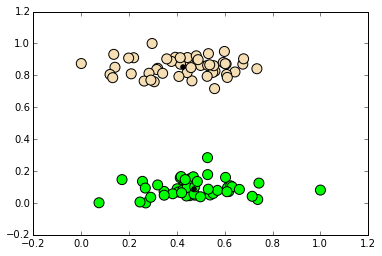

In [319]:
AffichagesClusters(resCentr['1'],res['1'],points)

In [320]:
datax = createXOR(10,0.01)

In [321]:
gx =grid(datax,3,0.1)
gx.create_grid()

In [322]:
resx,resCentrx = gx.get_all_clusters_all_dim()

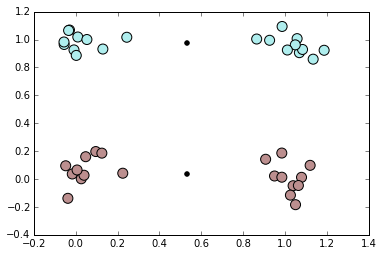

In [323]:
AffichagesClusters(resCentrx['1'],resx['1'],datax)

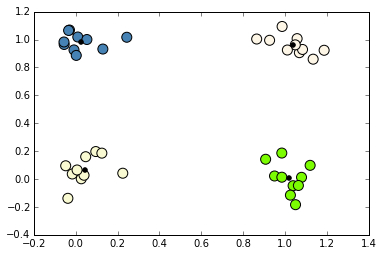

In [324]:
AffichagesClusters(resCentrx['01'],resx['01'],datax)

In [325]:
positive_pointsV = np.random.multivariate_normal(np.array([0,0]),np.array([[0,1],[0.005,0]]),51)
negative_pointsV = np.random.multivariate_normal(np.array([1,0]),np.array([[0,1],[0.005,0]]),52)
pointsV =pd.DataFrame(np.concatenate((positive_pointsV, negative_pointsV), axis=0))
pointsV = normalisation(pointsV)

In [326]:
gv =grid(pointsV,3,0.1)
gv.create_grid()

In [327]:
resV,resCentrV = gv.get_all_clusters_all_dim()

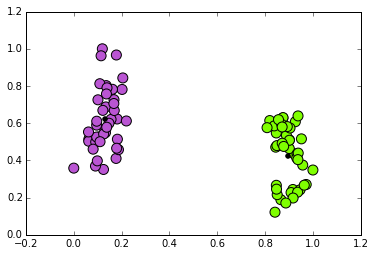

In [329]:
AffichagesClusters(resCentrV['01'],resV['01'],pointsV)

In [336]:
positive_pointsP = np.random.multivariate_normal(np.array([0,1]),np.array([[0,1],[0.08,0]]),50)
negative_pointsP = np.random.multivariate_normal(np.array([0,0]),np.array([[1,0],[0,0.08]]),50)
pointsP =pd.DataFrame(np.concatenate((positive_pointsP, negative_pointsP), axis=0))
pointsP = normalisation(pointsP)

In [337]:
gp =grid(pointsP,3,0.001)
gp.create_grid()

In [338]:
resP,resCentrP = gp.get_all_clusters_all_dim()

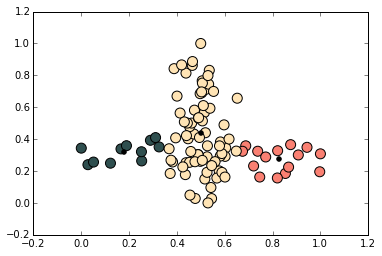

In [339]:
AffichagesClusters(resCentrP['01'],resP['01'],pointsP)

In [312]:
import matplotlib
import colorsys

def AffichagesClusters(centroides,dictAffectation,base):
    ind_points = []
    for cle,val in dictAffectation.items() :
        ind_points += val
    if(len(ind_points) < len(base)) :
        base_real = pd.DataFrame()
        base_real = base_real.append(base.iloc[ind_points[0:]])
        M_data2D = base_real.as_matrix() 
    else : 
        M_data2D = base.as_matrix() 
    colonne_X= M_data2D[0:,0] 
    colonne_Y= M_data2D[0:,1] 
    #Nombre de couluers
    colorNbr = len(centroides)
    #Choix aléatoire des couleurs
    colorNames = list(matplotlib.colors.cnames.keys())
    colors = [i for i in range(len(colorNames))]
    random.shuffle(colors)
    colors =colors[0:colorNbr]   
    colorMap = [] 
    for i in range(colorNbr) :
        colorMap.append(colorNames[colors[i]])
    colorMap = np.array(colorMap)

    #categories = np.zeros(len(base))
    #categories = np.array(categories)
    categories = {}
    for key,values in dictAffectation.items() :
        for indice in values :
            categories[indice] = int(key)
    #categories = categories.astype(int)
    plt.scatter(colonne_X,colonne_Y,s=100,c=colorMap[np.array(categories.values()).astype(int)])
    
    #Affichage des centroides finaux en noir 
    M_data2D = centroides.as_matrix()
    colonne_X= M_data2D[0:,0]
    colonne_Y= M_data2D[0:,1]
    plt.scatter(colonne_X,colonne_Y,color='black')
# Fonction d'affichage des résultats
def affichageResults(les_centres, l_affectation,nb_iter,convergence) :
    print("Le nombre d'itération : ",nb_iter)
    print("convergence : ", convergence)
    print("Les centres : \n",les_centres)
    print("Les affectations : \n")

    for c,v in l_affectation.items() :
        print("Cluster",c," : ",v)

    AffichagesClusters(les_centres, l_affectation,points)